In [1]:
import utils
import hrr_utils
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

past, present, freq = utils.GetRegularVerbs(True)
N = 1000

In [2]:
dic = hrr_utils.GenerateDefaultDictionary(N)
past, present, freq = utils.Shuffle(past, present, freq)

test_present = present[:int(len(present)*.2)]
test_past = past[:int(len(present)*.2)]

train_present=present[int(len(present)*.2):]
train_past=past[int(len(present)*.2):]

In [6]:
clipped_test_present_inp = []
clipped_test_past_inp = []

for i in range(len(test_present)):
    ivec = hrr_utils.GetRVClip(test_present[i], dic)
    evec = hrr_utils.GetRVClip(test_past[i], dic)
    clipped_test_present_inp.append(ivec)
    clipped_test_past_inp.append(evec)
    
clipped_test_present_inp = np.array(clipped_test_present_inp)
clipped_test_past_inp = np.array(clipped_test_past_inp)

clipped_train_present_inp = []
clipped_train_past_inp = []

for i in range(len(train_present)):
    ivec = hrr_utils.GetRVClip(train_present[i], dic)
    evec = hrr_utils.GetRVClip(train_past[i], dic)
    clipped_train_present_inp.append(ivec)
    clipped_train_past_inp.append(evec)
    
clipped_train_present_inp = np.array(clipped_train_present_inp)
clipped_train_past_inp = np.array(clipped_train_past_inp)

In [4]:
unclipped_test_present_inp = []
unclipped_test_past_inp = []

for i in range(len(test_present)):
    ivec = hrr_utils.GetRV(test_present[i], dic)
    evec = hrr_utils.GetRV(test_past[i], dic)
    unclipped_test_present_inp.append(ivec)
    unclipped_test_past_inp.append(evec)
    
unclipped_test_present_inp = np.array(unclipped_test_present_inp)
unclipped_test_past_inp = np.array(unclipped_test_past_inp)

unclipped_train_present_inp = []
unclipped_train_past_inp = []

for i in range(len(train_present)):
    ivec = hrr_utils.GetRVClip(train_present[i], dic)
    evec = hrr_utils.GetRVClip(train_past[i], dic)
    unclipped_train_present_inp.append(ivec)
    unclipped_train_past_inp.append(evec)
    
unclipped_train_present_inp = np.array(unclipped_train_present_inp)
unclipped_train_past_inp = np.array(unclipped_train_past_inp)

In [50]:
def neural_net(layer_size=[1000,1000], non_linearity=[0, 1], pre_encode=None, encode_fn=None,
               EPOCH=100, LEARNING_RATE=1e-2, non_linear_fn=tf.sigmoid):
    """
    pre_encode: If None, encode_fn needs to be defined.
        Otherwise (train_present, train_past, test_present, test_past)
    encode_fn will take in two strings, (present, past) and return a
        hypervec representation (vec_pres, vec_past)
    
    if EPOCH == 1, then function will track loss over seen data points
        every 50 iterations
    
    """
    train_mean = []
    test_mean = []
    train_std = []
    test_std = []
    
    if pre_encode == None:
        train_present_inp = []
        train_past_inp = []

        test_present_inp = []
        test_past_inp = []
        
        for i in range(len(train_present)):
            v = encode_fn(train_present[i], train_past[i])
            train_present_inp.append(v[0])
            train_past_inp.append(v[0])
        
        for i in range(len(test_present)):
            v = encode_fn(test_present[i], test_past[i])
            test_present_inp.append(v[0])
            test_past_inp.append(v[0])
        train_present_inp = np.array(train_present_inp)
        train_past_inp = np.array(train_past_inp)
        test_present_inp = np.array(test_present_inp)
        test_past_inp = np.array(test_past_inp)
    else:
        train_present_inp = pre_encode[0]
        train_past_inp = pre_encode[1]
        test_present_inp = pre_encode[2]
        test_past_inp = pre_encode[3]
    
    train_present_inp = train_present_inp.astype(np.float32)
    train_past_inp = train_past_inp.astype(np.float32)
    
    test_present_inp = test_present_inp.astype(np.float32)
    test_past_inp = test_past_inp.astype(np.float32)
    
    inp_vec = tf.placeholder(tf.float32, [None, N])
    exp_vec = tf.placeholder(tf.float32, [None, N])
    
    Ws = []
    bs = []
    hs = [inp_vec]
    
    for i in range(len(layer_size)-1):
        Ws.append(tf.Variable(tf.truncated_normal(shape=[layer_size[i], layer_size[i+1]], stddev=0.1)))
        bs.append(tf.Variable(tf.truncated_normal(shape=[layer_size[i+1]], stddev=0.1)))
        h = tf.matmul(hs[-1], Ws[-1])+bs[-1]
        
        if non_linearity[i+1] == 1:
            h = non_linear_fn(h)
            h = h-tf.reduce_mean(h)
        hs.append(h)
        
    # Output layer
    infer_vec = tf.sign(h)
    similarity = tf.diag_part(tf.matmul(infer_vec, tf.transpose(tf.sign(exp_vec))))


    loss = tf.reduce_mean(tf.contrib.losses.absolute_difference(predictions=h, targets=exp_vec))
    train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    if EPOCH == 1:
        # One shot training, need to batch every 50 examples loss
        train_loss_iter = []
        for i in range(len(train_present_inp)):
            if i%50 == 1:
                test_mean.append(sess.run(similarity, 
                                          feed_dict={inp_vec:test_present_inp, exp_vec:test_past_inp}).mean()/N)
                test_std.append(sess.run(similarity, 
                                          feed_dict={inp_vec:test_present_inp, exp_vec:test_past_inp}).std()/N)
                train_mean.append(sess.run(similarity, 
                                                 feed_dict={inp_vec:train_present_inp[:i], exp_vec:train_past_inp[:i]}).mean()/N)
                train_std.append(sess.run(similarity, 
                                                 feed_dict={inp_vec:train_present_inp[:i], exp_vec:train_past_inp[:i]}).std()/N)


                sess.run(train_op,
                         feed_dict={inp_vec:train_present_inp[i].reshape((1, -1)), exp_vec:train_past_inp[i].reshape((1, -1))})
            
    else: 
        for step in range(EPOCH):
            train_loss_iter = []
            test_mean.append(sess.run(similarity, 
                                      feed_dict={inp_vec:test_present_inp, exp_vec:test_past_inp}).mean()/N)
            test_std.append(sess.run(similarity, 
                                 feed_dict={inp_vec:test_present_inp, exp_vec:test_past_inp}).std()/N)

            train_mean.append(sess.run(similarity, 
                                             feed_dict={inp_vec:train_present_inp, exp_vec:train_past_inp}).mean()/N)
            train_std.append(sess.run(similarity, 
                                 feed_dict={inp_vec:train_present_inp, exp_vec:train_past_inp}).std()/N)

            sess.run(train_op,
                     feed_dict={inp_vec:train_present_inp, exp_vec:train_past_inp})
    
    return train_mean, train_std, test_mean, test_std

In [33]:

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product'):
    """
    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc='lower right')
    plt.show()
    #fig.savefig('test.jpg')
    """
    
    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc='upper left')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.tight_layout()

## NN Graph 1.1: 

* n = 1000
* linear everything
* one layer
* encoded with clipped naive encoding
* EPOCH = 1

In [38]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], pre_encode=
           (clipped_train_present_inp, clipped_train_past_inp, clipped_test_present_inp, clipped_test_past_inp),
          EPOCH = 1)

(40,)


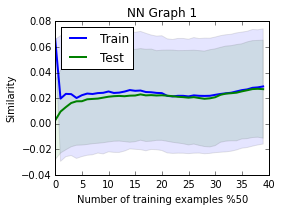

In [39]:
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

print train_mean.shape

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of training examples %50", ylabel="Similarity")

## NN Graph 1.2 

* n = 1000
* linear everything
* one layer
* encoded with clipped naive encoding
* EPOCH = 50

In [36]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], pre_encode=
           (clipped_train_present_inp, clipped_train_past_inp, clipped_test_present_inp, clipped_test_past_inp),
          EPOCH = 50)

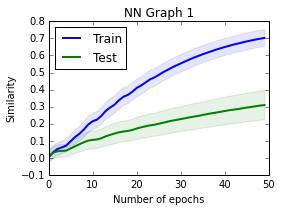

In [37]:
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of epochs", ylabel="Similarity")

## NN Graph 2.1

* n = 1000
* linear everything
* one layer
* encoded with unclipped naive encoding
* EPOCH = 1

In [41]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], pre_encode=
           (unclipped_train_present_inp, unclipped_train_past_inp, unclipped_test_present_inp, unclipped_test_past_inp),
          EPOCH = 1)

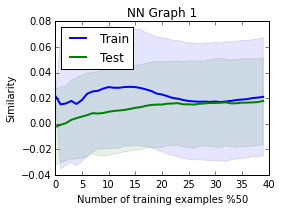

In [42]:
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of training examples %50", ylabel="Similarity")

## NN Graph 2.2

* n = 1000
* linear everything
* one layer
* encoded with unclipped naive encoding
* EPOCH = 50

In [43]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], pre_encode=
           (unclipped_train_present_inp, unclipped_train_past_inp, unclipped_test_present_inp, unclipped_test_past_inp),
          EPOCH = 50)

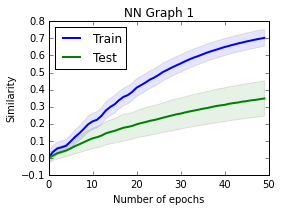

In [44]:
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of epochs", ylabel="Similarity")

## NN Graph 3.1
Dual encoding
* n = 1000
* linear everything
* one layer
* encoded with unclipped, diff-encoding
* EPOCH = 50

In [48]:
dicA = hrr_utils.GenerateDefaultDictionary(N)
dicB = hrr_utils.GenerateDefaultDictionary(N)

def diff_encode(str1, str2):
    """
    Encodes present, past into
    (present_A-past_A)*pres_B, past_B
    """
    prvec = hrr_utils.GetRV(str1, dicA)
    pavec = hrr_utils.GetRV(str2, dicA)
    prvec2 = hrr_utils.GetRV(str1, dicB)
    pavec2 = hrr_utils.GetRV(str2, dicB)
    
    return np.multiply(prvec-pavec, prvec2), pavec2
    


In [55]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], encode_fn=diff_encode,
          EPOCH = 50)

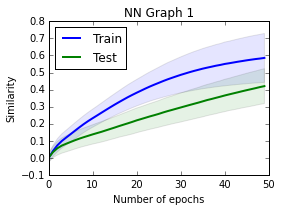

In [56]:
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of epochs", ylabel="Similarity")

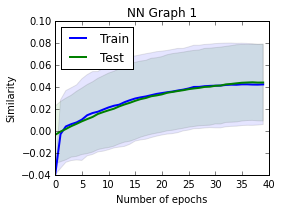

In [53]:
(train_mean, train_std, test_mean, test_std) = neural_net([1000, 1000], [0, 0], encode_fn=diff_encode,
          EPOCH = 1)
train_mean = np.array(train_mean)
train_std = np.array(train_std)
test_mean = np.array(test_mean)
test_std = np.array(test_std)

graph(np.arange(train_mean.shape[0]),train_mean,test_mean,train_std,test_std,"NN Graph 1",
     xlabel="Number of epochs", ylabel="Similarity")

## NN Graph 3.1
Dual encoding
* n = 1000
* linear everything
* one layer
* encoded with unclipped, diff-encoding
* EPOCH = 50